<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12회차: RNN을 활용한 항공 여행자 수 예측 (2) - 데이터 전처리 및 분석

## MinMax 데이터 정규화

In [1]:
# 운영체제 경로, 파일 조작 등을 위한 표준 라이브러리
import os
# 데이터프레임 형태로 데이터 처리 (엑셀/CSV 등 표 형식 데이터 분석)
import pandas as pd
# 수치 계산, 배열 연산 등을 위한 과학 계산 라이브러리
import numpy as np
# 딥러닝 모델 구성 및 학습을 위한 프레임워크 (RNN, LSTM 등 사용 가능)
import tensorflow as tf
# KaggleHub에서 공개 데이터셋을 다운로드할 수 있는 유틸리티
import kagglehub
# 데이터 시각화를 위한 기본 그래프 라이브러리
import matplotlib.pyplot as plt
# 데이터 정규화를 위한 전처리 도구 (예: 0~1 사이로 MinMax 스케일링)
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 1. 데이터 로드 및 전처리

# KaggleHub에서 "AirPassengers" 시계열 데이터셋을 다운로드
# 데이터셋 ID: pattnaiksatyajit/air-passengers
path = kagglehub.dataset_download("pattnaiksatyajit/air-passengers")
# 다운로드한 경로에서 'AirPassengers.csv' 파일 경로 생성
csv_file_path = os.path.join(path, "AirPassengers.csv")
# CSV 파일을 판다스 DataFrame으로 읽어오기
df = pd.read_csv(csv_file_path)
# DataFrame 구조 및 열 정보 출력 (결측값, 타입, 행 수 확인용)
df.info()

100%|██████████| 764/764 [00:00<00:00, 1.57MB/s]

Extracting files...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
# 문자열 형식의 'Month' 열을 pandas의 datetime 타입으로 변환
# 예: '1949-01' → Timestamp('1949-01-01 00:00:00')
df['Month'] = pd.to_datetime(df['Month'])

# 'Month' 열을 DataFrame의 인덱스로 설정
# 시간 순서 기반 시계열 분석, 시각화 등에 유리하게 만듦
# inplace=True → 원본 df를 바로 수정
df.set_index('Month', inplace=True)

# DataFrame의 구조, 열 이름, 결측값, 데이터 타입, 메모리 사용량 등을 출력
# 데이터 확인의 첫 단계로 자주 사용함
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


### MinMax Scaling
- 데이터를 최소값 0, 최대값 1 사이로 선형 변환하는 정규화 방법
  - 데이터의 범위를 [0, 1]로 압축
  - 이상치가 적고, 값의 분포가 균일할 때 적합
  - RNN, LSTM, CNN 등 신경망 학습 시 입력값을 일정 범위로 맞추기 위해 자주 사용
- 변환 공식
> <div style="text-align:left">
> $$
> x_{\text{scaled}}=\frac{x-x_{\min}}{x_{\max}-x_{\min}}
> $$
> <div>


In [6]:
# 데이터 정규화를 위한 전처리 도구 (예: 0~1 사이로 MinMax 스케일링)
from sklearn.preprocessing import MinMaxScaler

# -------------------------------------------------------------
# 2. MinMax Scaling 적용
#    '#Passengers' 열을 0~1 범위로 정규화
# -------------------------------------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['#Passengers']])  # 결과는 numpy array

# -------------------------------------------------------------
# 원본 값에서 최소/최대값의 "정수형 위치 인덱스" 추출
#    idxmin(): 최소값의 시계열 인덱스 → get_loc(): 정수형 위치로 변환
# -------------------------------------------------------------
psg = df['#Passengers']
idx_min = psg.index.get_loc(psg.idxmin())  # 예: 10
idx_max = psg.index.get_loc(psg.idxmax())  # 예: 138

# -------------------------------------------------------------
# 결과 출력: 원본 범위 vs 스케일링 결과 확인
# -------------------------------------------------------------
print("최소값 위치 인덱스:", idx_min)
print("최대값 위치 인덱스:", idx_max)
print("원본 최소/최대값:", psg.min(), psg.max()) # 104, 622

print("스케일링된 데이터 타입과 크기:", type(scaled_data), scaled_data.shape)
print("스케일링된 최소/최대값:", scaled_data.min().item(), scaled_data.max().item())

최소값 위치 인덱스: 10
최대값 위치 인덱스: 138
원본 최소/최대값: 104 622
스케일링된 데이터 타입과 크기: <class 'numpy.ndarray'> (144, 1)
스케일링된 최소/최대값: 0.0 1.0


In [11]:
scaled_data

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [7]:
psg.idxmin() # 결과는 현재 인데스인 Timestamp

Timestamp('1949-11-01 00:00:00')

In [9]:
df.loc[psg.idxmin()]

,1949-11-01
#Passengers,104


In [10]:
df.loc[psg.idxmax()]

,1960-07-01
#Passengers,622


In [12]:
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.5 MB/s eta 0:00:00


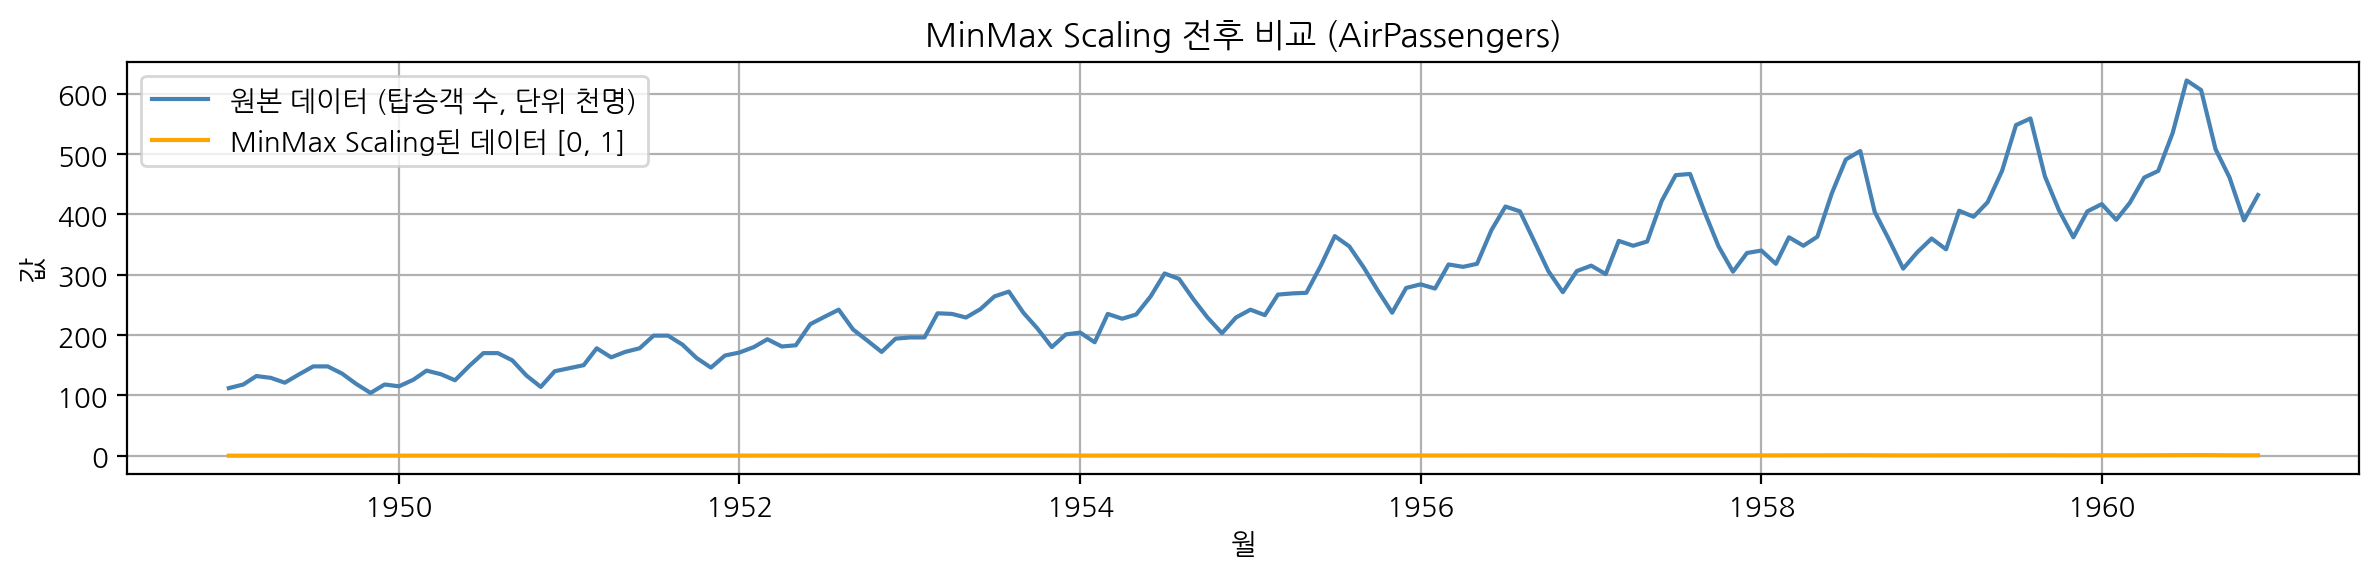

In [14]:
# 스케일된 결과를 Pandas Series로 변환하여 시계열 인덱스(df.index)와 매칭
# flatten() → (144, 1) 형태의 array를 (144,) 1차원으로 펴줌
scaled_series = pd.Series(scaled_data.flatten(), index=df.index)

# 시각화 시작: 원본 vs 스케일링 결과 비교
plt.figure(figsize=(12, 3))  # 가로 12인치, 세로 3인치 크기의 그래프 생성

# 원본 데이터 선 그래프: 파란색, 실제 탑승객 수
plt.plot(df.index, df['#Passengers'], label='원본 데이터 (탑승객 수, 단위 천명)', color='steelblue')
# 정규화된 데이터 선 그래프: 주황색, 0~1 사이 값
plt.plot(df.index, scaled_series, label='MinMax Scaling된 데이터 [0, 1]', color='orange')

# 그래프 제목 및 축 레이블 설정
plt.title("MinMax Scaling 전후 비교 (AirPassengers)")
plt.xlabel("월")           # X축: 월(시계열)
plt.ylabel("값")           # Y축: 값 (탑승객 수 또는 정규화된 수치)

# 범례 표시 및 격자 추가
plt.legend()
plt.grid(True)
# 레이아웃 자동 정리 및 시각화 출력
plt.tight_layout()
plt.show()

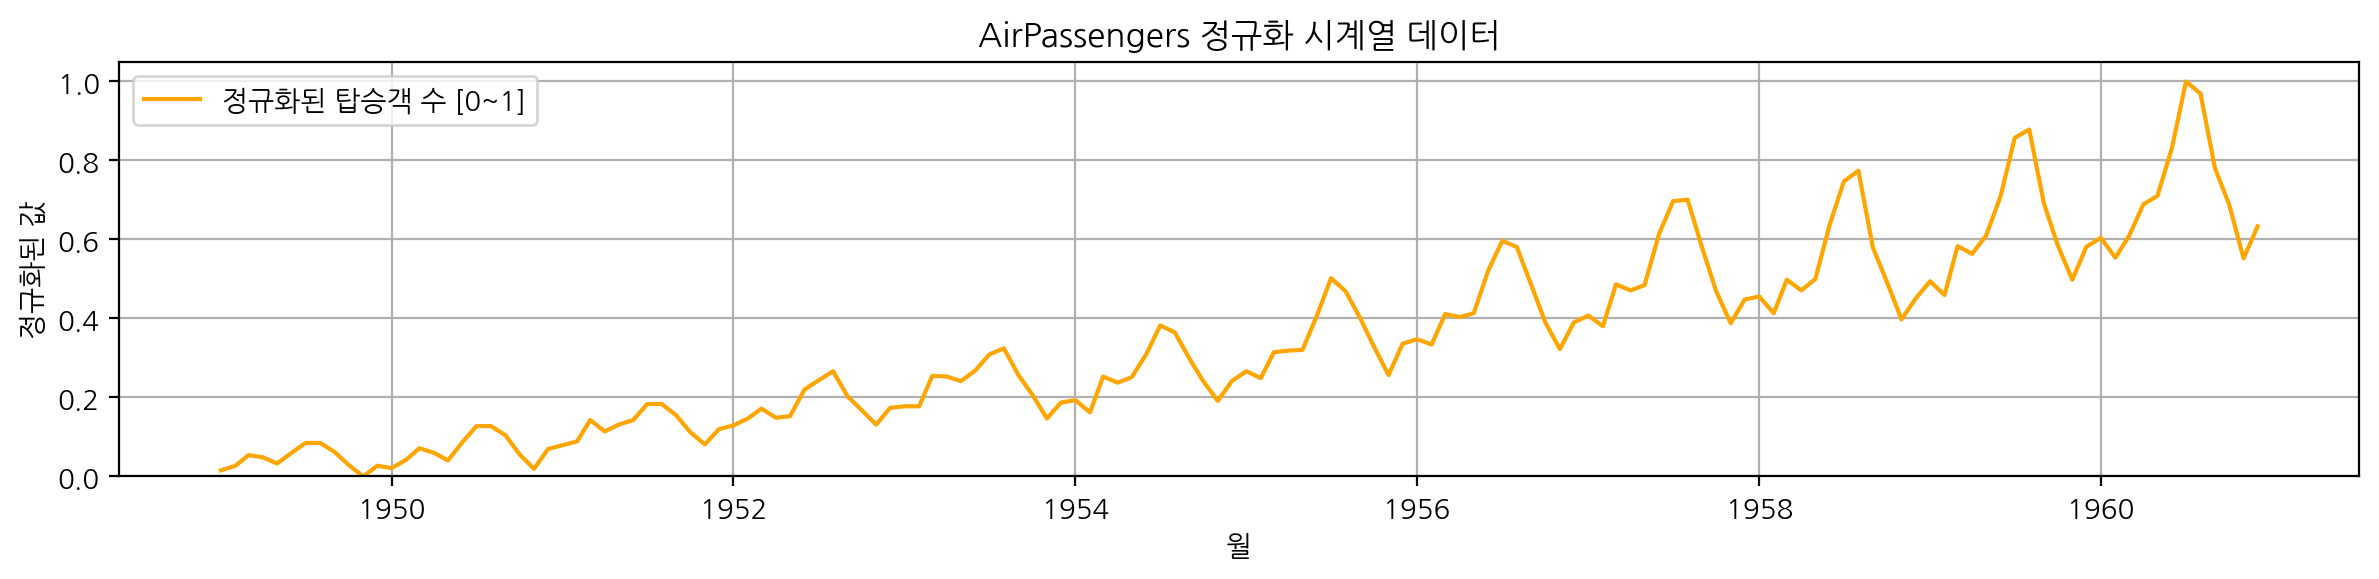

In [15]:
# 정규화된 값을 시계열 인덱스와 함께 Series로 변환
scaled_series = pd.Series(scaled_data.flatten(), index=df.index)

# 정규화된 값만 시각화
plt.figure(figsize=(12, 3))
plt.plot(scaled_series, color='orange', label='정규화된 탑승객 수 [0~1]')
plt.title("AirPassengers 정규화 시계열 데이터")
plt.xlabel("월")
plt.ylabel("정규화된 값")
plt.ylim(0, 1.05)  # y축 범위를 명확히 0~1로 지정
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Airpassengers 데이터 사분할

In [16]:
# 3. Sliding Window 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)
X_all.shape, y_all.shape

((132, 12, 1), (132, 1))

### Sliding Window 방식으로 (입력 시퀀스 X, 정답 y) 쌍을 자동으로 만들어주는 함수
- data: 전체 시계열 데이터 (예: 항공 승객 수, 주가, 온도, 센서 신호 등)
- seq_length: 하나의 입력 시퀀스를 구성할 데이터 길이 (윈도우 크기)
- data[i:i+seq_length]: 시점 i부터 seq_length만큼 자른 입력 시퀀스
- data[i+seq_length]: 다음 시점 값 → 정답 레이블로 사용
- 예: seq_length = 3, data = [1, 2, 3, 4, 5]일 경우, X = [[1,2,3], [2,3,4]], y = [4, 5]


In [17]:
scaled_data[:13]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552]])

In [18]:
X_all[0], y_all[0]

(array([[0.01544402],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703]]),
 array([0.02123552]))

### 데이터를 학습/검증/테스트 데이터 분할 시 고려사항
- 무작위로 분할한다면 시간적인 의미가 깨질 수 있음
- 시간 순서를 그대로 유지해서 Train/Validation/Test 분할
  - 전체 수 n의 70%를 훈련(train), 다음 15% 검증(val), 마지막 15%를 테스트(test)로 할당
  - shuffle 없이 시간 순서대로 나누는 것이 핵심
- 시퀀스 수(n)가 132일 때 실제 분할


In [19]:
# 4. 시간 순서 유지하며 Train/Val/Test 분할

# 전체 시퀀스 개수 확인 (Sliding Window로 생성된 샘플 수)
n = len(X_all)
# 훈련 데이터 종료 인덱스: 전체의 70% 지점
train_end = int(n * 0.7)
# 검증 데이터 종료 인덱스: 전체의 85% 지점
val_end = int(n * 0.85)

# 훈련 세트: 시계열 앞부분 70%
X_train, y_train = X_all[:train_end], y_all[:train_end]
# 검증 세트: 다음 15% (하이퍼파라미터 튜닝용)
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
# 테스트 세트: 가장 마지막 15% (모델 성능 평가용)
X_test, y_test = X_all[val_end:], y_all[val_end:]

# 각 세트의 입력 시퀀스(shape: 샘플 수, 시퀀스 길이, 피처 수) 출력
print(X_train.shape, X_val.shape, X_test.shape)
# 각 세트의 정답 벡터(shape: 샘플 수,) 출력
print(y_train.shape, y_val.shape, y_test.shape)

(92, 12, 1) (20, 12, 1) (20, 12, 1)
(92, 1) (20, 1) (20, 1)


## 종료